### Exploratory Data Analysis

    Given any sort of raw data, the first thing I'll try to do is understand the data, as it comprises the
    raw materials from which the solution will be built. Given that the task is to predict a house's sale
    price, we want to understand the prices of the houses we are looking at, and look at how each of 
    the data points available influence the house price.
    
    This analysis will help provide insights that will serve in how we clean, prepare and transform the data,
    prior to modelling the problem.
    
    To inform a disciplined study of the problem, we will go through the following processes:
    
    1. Univariate Analysis: In this step, we will focus on `SalePrice` to try to know a little bit about it
    
    ... Documenting steps as I go through each...

**Exploratory Data Analysis:**

    1. Understand the problem: We will look at each variable and do a philosophical analysis about their 
       meaning and importance for this problem
    2. Univariable study. We'll just focus on the dependent variable ('SalePrice') and try to know a 
       little bit more about it.
    3. Multivariate study. We'll try to understand how the dependent variable and independent variables relate.
    4. Basic cleaning. We'll clean the dataset and handle the missing data, outliers and categorical variables.
    5. Test assumptions. We'll check if our data meets the assumptions required by most multivariate techniques.

**Import Packages**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import StandardScaler

import utils

In [2]:
%matplotlib inline

In [3]:
# Seaborn Settings
sns.set() # Theme

### Prepare Data

#### Import Data

In [4]:
def wrangle_data(data_path):
    """Given a data - stored in a particular file-path - import
    and manipulate data set for easier analysis
    
    Parameters:
    -----------
    data_path : str
        File path to the data source
        
    Returns:
    --------
    df : pd.DataFrame
        A pandas DataFrame
    """
    
    # Import data (from csv file)
    df = pd.read_csv(data_path)
    
    # Drop `low-high cardinality` features
    drop_cols = ["Id"]
    
    
    
    # Drop features
    df.drop(columns=drop_cols, inplace=True)
    
    return df

In [5]:
#     # Drop `Multi-collinearity` features
#     drop_cols = ["1stFlrSF", "YearBuilt", "TotRmsAbvGrd"]
    
#     # Drop `low-and-high cardinality` features
#     drop_cols.append("Id")
    
#     # Find and drop features > 15% missing data
#     percent_missing_data = (df.isna().sum() / df.isna().count()).sort_values(ascending=False)
#     missing_data_cols = percent_missing_data[percent_missing_data > 0.15].index
#     drop_cols.extend(missing_data_cols)
    
#     # Drop obversations with NaN
# #     df.dropna(inplace=True)
    
    
#     # Drop Columns
#     df.drop(columns=drop_cols, inplace=True)

In [6]:
df = wrangle_data("data/train.csv")
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [8]:
df.shape

(1460, 80)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

    Observations
    
    Our dataset has 1,460 observations and 71 features (or data-points). One thing we will need to check
    is where the number of observations are unique and not duplicated. Further, given that the dataset
    contains 71 data-points, we will have to find a way to analysis this data for data points that are 
    relevant to predicting sale price.
    
    In some sort of way, we will need to conduct features selection; this will be done gradually through
    out this analysis.

    💡 By looking at the data-info, we observe that PoolQC, Fence, MiscFeature, FireplaceQu, Alley, etc
    have a lot of missing values in them. Therefore, we will need to handle these missing values in the
    process.
    
    💡 Feature `Id` looks like it represents a count of the observations; we will have to delete this as
    it provides no meaning to the problem.

In [10]:
# Drop "Id" columns
# df.drop(columns="Id", inplace=True)

    In order to understand our data, we will look at each variable and try to understand its meaning
    and relevance to this problem.
    
    In order to have some discipline in my analysis, I've adopted the idea of creating a spreadsheet
    with the following columns:
    
    1. Variable: Variable name
    2. Type: Variable's type; either `numerical` - int, float or `categorical` - for categorical values
    3. Segment: Identification of the variable's segment. We define three possible segments: building, 
       space or location.
    4. Expectation: Our expectation about the variable influence in `SalePrice.` We can define a categorical
       scale of `High`, `Medium` or `Low`
    5. Conclusion: Our conclusions about the importance of the variable, after we give a quick look at the
       data. We can define a categorical scale of `High`, `Medium` or `Low`.
    6. Comments: Any general comments

Analyst found here - [Spreadsheet](https://docs.google.com/spreadsheets/d/1HXOq9GMguCRamvw5YH8CQJececkYsrNYrpygL_pMJ3M/edit?usp=sharing)

    After a subjective and research analysis of each variable's relevance to `SalePrice`,
    I ended up with the following features:

|Feature|Expectation|Comments|
|-------|-----------|-------|
|MSZoning|High|We'd expect the zoning classification to incluenece the price of a house. E.g. With all otherfactors constant, a home in commercial zoning would be priced differently from that in industrail zoning.|
|Neighborhood|High|Definitely, neighborhood affects the price of a house|
|OverallQual|High|Overall material and finish of a house matters in pricing|
|OverallCond|High|Overall condition matters in pricing too|
|1stFlrSF|High|First floor area basically tells us how big the house is in surface area, therefore, it matters|
|2ndFlrSF|High|Same as first floor area|
|GrLivArea|High|Same as the 1stFlrSF and 2ndFlrSF|
|HouseStyle|Medium|We'd expect a different in pricing between 1Story and 2Story building|
|TotBsmtSF|Medium|With all other factors constant, a house with a bigger basement would be more expensive|
|Bedroom|Medium|For obvious reasons, this matters|
|GarageCars|Medium|A house with a garage that can have more cars might be pricy|
|GarageArea|Medium|The bigger the garage area, the more cars can pack in it. There might be multi-collinearity here|
|PoolArea|Medium|The presense of a swimming pool hicks the house price|
|MiscFeature|Medium|Depending on the Misc Feature, the price might be influence or not|

### Explore

    Firstly, we will start by conducting a Univariate Analysis/Study on the `SalePrice`. The purpose for this is
    to get knowledge about variable - We will perform some basic analysis including Measures of Central Tendency,
    and Measures of Variability.

**Univariate Analysis of `SalePrice`**

We will start by looking at the `Mean`, `Mode` and `Median`.

In [11]:
sale_price = df['SalePrice']

# Mode
mode = stats.mode(sale_price, axis=None)
mode_series = pd.Series(data={"mode": mode[0][0]})

# Min, Max, Median Price
agg = (
    sale_price
    .aggregate(['mean', 'median'])
    .append(mode_series)
    .to_frame()
)

agg.columns = ["SalePrice"]
agg

,SalePrice
mean,180921.19589
median,163000.00000
mode,140000.00000


    💡 The Mean, Median and Mode differ by about 20,000. This indicates the presense of outliers. Generally
    thinking about it, we would expect a distribution for selling price where the majority of house fall within
    a certain bracket and a few houses would be more expensive or less expensive.
    
    Let's inspect a few distribution to check this further.

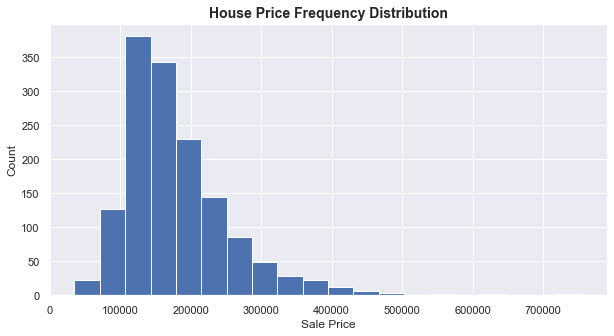

In [12]:
# `SalePrice` Distribution
utils.plot_distribution_hist(sale_price, "House Price Frequency Distribution", "Sale Price", "Count")

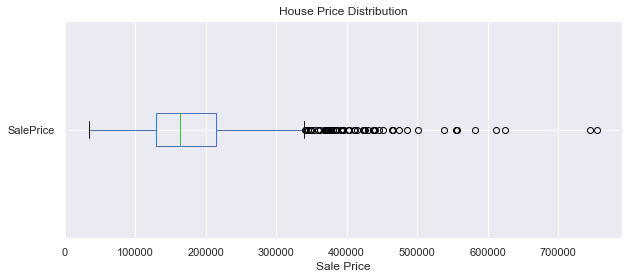

In [13]:
utils.plot_distribution_boxplot(sale_price, "House Price Distribution", "Sale Price")

* `SalePrice` is not normally distribution, as we confirmed earlier by looking at the Mean, Mode and Median.
  Ideally, `SalePrice` should be normally distributed; mean, mode and median should be equal.
* `SalePrice` is right-skewed
* In the boxplot, we observe the presense of outlier houses
    * 75% of the houses had a selling price less than ~220,000 USD.
    * 50% of the houses had a selling price less than the median (163,000 USD)
    
* 🎯 Going forward, we will have to deal with outliers; remove houses with selling prices that are way above
  the average houses.
* 🎯 We will also have to deal with the distribution to make sure it is normally distributed.
    

What's the difference between the least and most expensive house?

In [19]:
print("Range: ${}".format(sale_price.max() - sale_price.min()))

Range: $720100


`Analyze Numerical Features`

**SalePrice vs TotalBsmtSF**

In [ ]:
utils.plot_scatter_plot(
    x=df['TotalBsmtSF'], 
    y=sale_price, 
    title="House Sale Price ($) vs Total Basement Area (sq)",
    xlabel="Total Basement Area (sq)",
    ylabel="Sale Price"
)

In [ ]:
print("Sale Price vs TotalBsmtSF Correlation:", round(sale_price.corr(df['TotalBsmtSF']), 2))

    Summary
    
    * A positive linear-relationship exists between sale price (USD) and total basement area (sq); As the total
    basement area increases, so does the house sale price. 
    * We observe one house whose total basement area was higher than the rest, but had a selling price close to
    USD200,000

**Sale Price vs 1stFlrSF**

In [ ]:
# utils.plot_scatter_plot(
#     x=df['1stFlrSF'],
#     y=sale_price,
#     title="House Sale Price ($) vs First Floor (sq)",
#     xlabel="First Floor (sq)",
#     ylabel="Sale Price ($)"
# )

In [ ]:
# print("Sale Price vs 1stFlrSF Correlation:", round(sale_price.corr(df['1stFlrSF']), 2))

    Summary
    
    * A positive linear-relationship exists between sale price and first floor (sq); the more first floor
    - in square feet - the more the house sale price.
    * We observe another house whose first floor (sq) was outlier and cost ~USD200,000. Is it the same house
    seen in the previous analysis?

In [ ]:
# df[df['1stFlrSF'] > 4000][['Id', '1stFlrSF', 'TotalBsmtSF']]

    * Yep. Is's the same house

**Sale Price vs 2stFlrSF**

In [ ]:
utils.plot_scatter_plot(
    x=df['2ndFlrSF'],
    y=sale_price,
    title="House Sale Price ($) vs First Floor (sq)",
    xlabel="Second Floor (sq)",
    ylabel="Sale Price ($)"
)

In [ ]:
print("Sale Price vs 2ndFlrSF Correlation:", round(sale_price.corr(df['2ndFlrSF']), 2))

    Summary:
    
    * The scattter plot shows a positive linear-relationship between sale price and second floor (sq); 
    as the second floor area increases, so does the house selling price.
    * The correlation is at 0.32
    * We observe a number of houses whose second floor area (sq) is zero; perhaps these houses didn't have
    a second floor.

In [ ]:
# Inspect Houses with a value of 0 on 2ndFlrSF
df[df['2ndFlrSF'] == 0].shape

**Sale Price vs GrLivArea**

In [ ]:
utils.plot_scatter_plot(
    x=df["GrLivArea"],
    y=sale_price,
    title="House Sale Price vs Above Grade Living Area (sq)",
    xlabel="Above Ground Living Area",
    ylabel="Sale Price"
)

In [ ]:
print("Sale Price vs Above Ground Living Area Correlation:", round(sale_price.corr(df['GrLivArea']), 2))

    Summary:
    
    * Above Ground Living Area affects Sale Price such that as the area increases, so does the Sale Price; this
    indicated a positive linear-relationship between the two variables.
    * Again, the scatter plot shows outlier houses with an area above 4,500sq yet their sale price was less than
    USD200,000.

**Sale Price vs GarageArea**

In [ ]:
utils.plot_scatter_plot(
    x=df["GarageArea"],
    y=sale_price,
    title="House Sale Price vs Garage Area (sq)",
    xlabel="Garage Area (sq)",
    ylabel="Sale Price"
)

In [ ]:
print("Correlation: Sale Price vs Garage Area:", round(sale_price.corr(df["GarageArea"]), 2))

    Summary
    
    * Sale Price and Garage Area show a positive linear-relationship between them such that if the Sale Price
    increases as Garage Area (Space) increases.
    * A correlation of 0.62
    * Further, we observe a number of houses with Garage Area of 0; these might be houses that don't have a 
    garage.

**Sale Price vs PoolArea**

In [ ]:
utils.plot_scatter_plot(
    x=df["PoolArea"],
    y=sale_price,
    title="House Sale Price vs Pool Area (sq)",
    xlabel="Pool Area (sq)",
    ylabel="Sale Price"
)

    Summary
    
    * Interestingly, the majority of houses don't have a swimming pool; this might be indicated by the presense
    of a zero as the value for the majority of houses.
    * No relationship occurs between these two variables

In [ ]:
# df["PoolQC"].value_counts()

In [ ]:
# df["PoolQC"].isnull().sum()

    * `PoolArea` contains 1,453 missing values; we drop this feature before fitting a model 🎯

`Analyze Categorical Features`

**Sale Price vs Neighborhood**

In [ ]:
nghbrhood_counts = df["Neighborhood"].value_counts(normalize=True).sort_values()

In [ ]:
utils.plot_bar(
    data=nghbrhood_counts,
    title="Neighborhood Distribution",
    ylabel="Neighborhood",
    ticks_range=np.arange(0.0, 0.18, 0.02),
    labels=["0%", "2%", "4%", "6%", "8%", "10%", "12%", "14%", "16%"]
)

In [ ]:
utils.plot_box(
    data=df, 
    x="SalePrice", 
    y="Neighborhood", 
    title="Neighborhood vs Sale Price ($)",
    xlabel="Sale Price ($)",
    ylabel="Neighborhood"
)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))

# Barplot
df.groupby(by="Neighborhood")["SalePrice"].mean().sort_values().plot(kind="barh")

# Labels
plt.title("Neighborhoods Mean House Prices ($)")
plt.ylabel("Neighborhood")
plt.xlabel("Mean Sale Price ($)")

# Add x-grid lines
plt.grid(axis="x", linewidth=0.5, linestyle="--");

    Summary
    
    * Neighborhood affects the sale price
    * Depending on the neighborhood a house is in, that neighborhood has a mean selling price; e.g. The avg
    selling price of a house in NoRidge - `Northridge` is close to USD350,000 where as that of a house in
    MeadowV `Meadow Village` is close to USD100,000.

**SalePrice vs HouseStyle**

In [ ]:
# What type of styles do the houses have?
housestyle = df["HouseStyle"].value_counts(normalize=True).sort_values()

utils.plot_bar(
    data=housestyle, 
    title="Housestyle Distribution", 
    ylabel="Housestyle",
    ticks_range=np.arange(0.0, round(housestyle.max() + 0.1, 2), 0.1),
    labels=["0%", "10%", "20%", "30%", "40%", "50%"],
    figsize=(6, 6)
)

In [ ]:
utils.plot_box(df, "SalePrice", "HouseStyle", "House Style vs Sale Price ($)", "Sale Price (%)", "House Style")

    Summary
    
    * It seems `House Style` also affects the Sale Price

**SalePrice vs OverallCond**

In [ ]:
# Change dtype
df["OverallCond"] = df["OverallCond"].astype('category')

overall_cond = df["OverallCond"].value_counts(normalize=True).sort_values()
overall_cond

In [ ]:
utils.plot_bar(
    overall_cond, 
    "Overall Condition Distribution",
    "Overall Condition",
    ticks_range=np.arange(0.0, overall_cond.max() + 0.1, 0.1),
    labels=["0%", "10%", "20%", "30%", "40%", "50%", "60%"],
    figsize=(6, 6)
)

In [ ]:
utils.plot_box(
    data=df, 
    y="OverallCond", 
    x="SalePrice", 
    title="Overall Condition vs Sale Price ($)", 
    xlabel="Sale Price ($)", 
    ylabel="Overall Condition"
)

    Summary
    
    * The better the house's condition, the higher the avg selling price

**SalePrice vs Bedroom**

In [ ]:
df["BedroomAbvGr"] = df["BedroomAbvGr"].astype('category')

bedroom = df["BedroomAbvGr"].value_counts(normalize=True).sort_values()
bedroom

In [ ]:
utils.plot_bar(
    bedroom, 
    "Bedrooms Distribution",
    "Bedrooms",
    ticks_range=np.arange(0.0, overall_cond.max() + 0.1, 0.1),
    labels=["0%", "10%", "20%", "30%", "40%", "50%", "60%"],
    figsize=(6, 6)
)

In [ ]:
utils.plot_box(
    data=df, 
    y="BedroomAbvGr", 
    x="SalePrice", 
    title="Bedrooms vs Sale Price ($)", 
    xlabel="Sale Price ($)", 
    ylabel="Bedrooms"
)

    Summary
    
    * 75% of houses have 2 or 3 bedrooms above ground; 25% and 50% of the houses are 2-bedrooms and 3-bedrooms,
    respectively.
    * It looks like the number of bedrooms above ground doesn't really influence the house sale price.

**SalePrice vs GarageCars**

In [ ]:
df["GarageCars"] = df["GarageCars"].astype("category")

garage_car_capacity = df["GarageCars"].value_counts(normalize=True).sort_values()
garage_car_capacity

In [ ]:
# Size of Garage (Car Capacity) Distribution
utils.plot_bar(
    garage_car_capacity, 
    "Garage Car Capacity Distribution",
    "Garage Car Capacity",
    ticks_range=np.arange(0.0, overall_cond.max() + 0.1, 0.1),
    labels=["0%", "10%", "20%", "30%", "40%", "50%", "60%"],
    figsize=(6, 6)
)

In [ ]:
utils.plot_box(
    data=df, 
    y="GarageCars", 
    x="SalePrice", 
    title="Bedrooms vs Sale Price ($)", 
    xlabel="Sale Price ($)", 
    ylabel="Bedrooms"
)

    Summary
    
    * 50% of houses have a garage with a capacity of 2 cars
    * It seems the capacity of the garage influences the sale price of a house; however, we observe that
    as a house's garage car capacity increases from the 0 to 3, so does the sale price of the house.
    * In the visual, we see that the selling price of houses with a garage car capacity of 4 is slightly doesn't
    follow the trend; looking at the distribution, it looks more like there are not many houses with this
    car capacity and that which was available had a price that was slightly lower.

In [ ]:
# Houses with a Garage Car Capacity of 4
df[df["GarageCars"] == 4]

**Correlation Matrix**

    Here, we will explore the relationships in our data by calculating the correlation between them. This will
    enable us to see which features influence `SalePrice` and how, and which features are correlated with each
    other.

In [ ]:
# Correlation
corr = df.corr()

In [ ]:
# Draw Axis
fig, ax = plt.subplots(figsize=(12, 10))

# HeatMap
sns.heatmap(corr, vmax=.8, square=True);

    Summary
    
    * From a first glass, we see that `TotalBsmtSF` and `1stFlrSF` are highly correlated with each other; 
    multi-collinearity exists here. We can drop-off the feature with the smallest correlation between the two.
    * We also observe multi-collinearity on the features `OverallQual` <> `YearBuilt.` This makes sense; the
    overall quality of a house correlates with the year it was built; we'd expect a house built in 2022 to be 
    of good quality compared that built in the year 1990.
    
    * We also observe that SalePrice is correlated with `OverallQual`, `TotalBsmtSF`, `GarageArea`, 
    and `GrLivArea` - features we identified in our initial analysis.

In [ ]:
# Pick 10 highest correlated features
cols = corr.nlargest(10, 'SalePrice')["SalePrice"].index
# Calculate corr among those features
sale_price_top10_corr = df[cols].corr()

# Draw Axis
fig, ax = plt.subplots(figsize=(10, 8))
# Heatmap
sns.heatmap(sale_price_top10_corr, annot=True)
plt.show();

    The following are the 10 most correlated features:
    
    * `OverallQual`, `GrLivArea` and `GarageArea` are the most correlated features with `SalePrice`.
    * `GrLivArea` <> `TotRmsAbvGrd` and `TotalBsmtSF` <> `1stFlrSF` are correlated between themselves; this
    indicates multi-collinearity. Therefore, we remove the least correlated features to `SalePrice` in the
    pairs.

**Scatter plots between `SalePrice` and correlated variables**

In [ ]:
sns.set()

# Most correlated features
corr_feats = ["SalePrice", "OverallQual", "GrLivArea", "GarageArea", "TotalBsmtSF", "FullBath", "YearRemodAdd"]
# Pairplots
sns.pairplot(df[corr_feats]);

**Missing Data**

- How prevelant is the missing data?
- Is missing data random or does it have a pattern?

In [ ]:
# Number of missing values per column
total = df.isna().sum().sort_values(ascending=False)
# Percent of missing values per column
percent = ((df.isna().sum() / df.isna().count())).sort_values(ascending=False)

# Missing Data: DF
missing_data = pd.DataFrame(data={
    "Total": total,
    "Percent": percent
})

missing_data.head(20)

    Analysis
    
    * The features `PoolQC`, `MiscFeature`, `Alley`, etc have over 80% of the data missing; these features should
    be dropped from other data.
    * The garage features `GarageCond`, `GarageQual`, etc are missing 81 data points; it could be that the houses
    corresponding to these features didn't have a garage.
    * Same for the basement and masonry features.
    * Electical is only missing 1 data point, so we will remove this observations
    
    In general, if a feature has more than 15% of data missing, we will delete it. Otherwise, we will keep it,
    delete entries with those missing data points or try out imputation strategies.

In [ ]:
# percent_missing_data = (df.isna().sum() / df.isna().count()).sort_values(ascending=False)
# missing_data_cols = percent_missing_data[percent_missing_data > 0.15].index
# df.drop(columns=missing_data_cols)

In [ ]:
# df.dropna(inplace=True)

**Outliers**

Outliers are data points that appear extreme or outside the pattern compared to all other data-points in
a given variable. When building a model with data containing outliers, the model can be greatly affected
in performance; model a relationship that is not the case.

Therefore, it's important to detect and deal with outliers. Their are several methods for dealing with
outliers (Inter-Quartile Range, Standard Deviation, Z-Score, etc). However, in this analysis, we will do
a quick analysis through the standard deviation of `SalePrice` and a set of scatter-plots.

[Outlier Detection](https://towardsdatascience.com/outlier-detection-part1-821d714524c)

`SalePrice Univariate Analysis`

In [ ]:
sale_price.head()

In [ ]:
std_scaler = StandardScaler() # Instantiate StandardScaler
saleprice_scaled = std_scaler.fit_transform(df.loc[:, ["SalePrice"]]) # Transform data to have a mean=0 and std=1

# Top/Bottom 10 Distributions
lower = sorted(saleprice_scaled[:, 0])[:10]
upper = sorted(saleprice_scaled[:, 0])[-10:]

In [ ]:
print("Lower Range Distribution")
print(np.array(lower))

In [ ]:
print("Upper Range Distribution")
print(np.array(upper))

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

# Histogram
pd.Series(saleprice_scaled[:, 0]).plot(kind="hist", bins=20)

# Labels
plt.title("House Sale Price Distribution (Standardized Values)")
plt.ylabel("Frequency")
plt.xlabel("Sale Price (Standardized)");

    Observations
    
    * The majority of houses are similar; their standardized value is close to zero.
    * A small number of houses have a standard deviation of 2; the upper range values
      indicate the presense of outliers values; potentially going to 7 standard 
      deviations.
    
    * To deal with these, we can define a threshold, in-terms of standard deviations, 
      and remove any observations that are below or above that threshold.
      E.g.
      - Threshold = 2 Standard Deviations
      - Remove any observations that are more than 2 standard deviations above or below
        the mean.

In [ ]:
threshold_std = 2 # Number of standard Deviations to cap values
price_deviation = sale_price.std() * threshold_std # Calculate the price deviation

lower_bound = sale_price.mean() - price_deviation
upper_bound = sale_price.mean() + price_deviation

print("Upper bound:", upper_bound)
print("Lower bound:", lower_bound)

In [ ]:
# Filter data to remove observations below the lower bound and above the upper bound
# df = df[(df["SalePrice"] > lower_bound) & (df["SalePrice"] < upper_bound)]
df.shape

`SalePrice Bivariate Analysis`

In [ ]:
# SalePrice vs GrLivArea
utils.plot_scatter_plot(
    x=df["GrLivArea"],
    y=df["SalePrice"],
    title="House Sale Price vs Above Grade Living Area (sq)",
    xlabel="Above Ground Living Area",
    ylabel="Sale Price"
)

    Summary
    * We see two outlier houses with `GrLivArea` values of above 4000 yet their house price is lower than
      200,000 (USD).
    * We also see two outlier houses with `SalePrice` above 700,000 (USD) and `GrLivArea` above 4000. Further,
      we also see a couple of houses with sale prices slightly here. Note that these are the houses we observed
      to have `price deviation` above two standard deviations from the mean. Here, we remove all houses with
      `GrLivArea` 4000.

In [ ]:
print("Size of data before removing outliers:", df.shape)

# Filter data to remove outlier houses based on `GrLivArea`
grlivarea_mask = df["GrLivArea"] < 4000
df = df[grlivarea_mask]

print("Size of data after removing outliers:", df.shape)

In [ ]:
# SalePrice vs TotalBsmtArea
utils.plot_scatter_plot(
    x=df['TotalBsmtSF'], 
    y=df["SalePrice"], 
    title="House Sale Price ($) vs Total Basement Area (sq)",
    xlabel="Total Basement Area (sq)",
    ylabel="Sale Price"
)

    Summary
    * We see a couple of outliers, but since the data points follow the trend, we will keep this.

`Note:` We can perform this analysis on all variables, but here, we will limit our analysis to these two for reason to do with just learning the techniques.